In [1]:
import random
import scipy
import math
from PIL import Image
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from networkx.generators.community import LFR_benchmark_graph

from networkx.algorithms.community import k_clique_communities
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import louvain_communities, louvain_partitions

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import mutual_info_score


plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),  # red   with alpha = 30%
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),  # green with alpha = 50%
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),  # blue  with alpha = 20%
})

# Part 1: Centrality [30 points]

### 1.1

In [2]:
def load_graphs():
    """
    
    Returns:
    G_airport: NetworkX Graph Object
    G_yeast: NetworkX Graph Object
    
    """
    G_airport = nx.read_edgelist('US_airports.txt', nodetype=int, data=(('weight', float),))
    
    G_yeast = nx.DiGraph()
    with open('Yeast.txt', 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) >= 2:
                G_yeast.add_edge(parts[0], parts[1])

    # Convert Yeast network to undirected for specific computations
    G_yeast_undirected = G_yeast.to_undirected()

    G_yeast = G_yeast.to_undirected()
    
    return G_airport, G_yeast

### 1.2

In [3]:
def top_10_nodes(G):
    """
    Inputs:
    G: NetworkX Graph Object
    
    Returns:
    top_10_nodes_dict: dict[list[int]]
    
    """
      # Eigenvector Centrality
    eigen_centrality = nx.eigenvector_centrality(G)
    eigen = sorted(eigen_centrality, key=eigen_centrality.get, reverse=True)[:10]

    # Katz Centrality
    adjacency_matrix = nx.adjacency_matrix(G).todense()
    #largest_eigenvalue = max(np.linalg.eigvals(adjacency_matrix))
    largest_eigenvalue = max(np.linalg.eigvals(adjacency_matrix).real)
    #alpha_katz = 1 / (largest_eigenvalue + 1e-5)
    alpha_katz = 1 / (largest_eigenvalue) 
    katz_centrality = nx.katz_centrality_numpy(G, alpha=alpha_katz)
    katz = sorted(katz_centrality, key=katz_centrality.get, reverse=True)[:10]

    page_rank_centrality = nx.pagerank(G, alpha=0.85)
    page_rank = sorted(page_rank_centrality, key=page_rank_centrality.get, reverse=True)[:10]


    G_unweighted = nx.Graph(G)

    closeness_centrality = nx.closeness_centrality(G_unweighted, wf_improved=False)
    closeness = sorted(closeness_centrality, key=closeness_centrality.get, reverse=True)[:10]

    harmonic_centrality = nx.harmonic_centrality(G_unweighted)
    harmonic = sorted(harmonic_centrality, key=harmonic_centrality.get, reverse=True)[:10]

    betweenness_centrality = nx.betweenness_centrality(G_unweighted)
    betweenness = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)[:10]


    top_10_nodes_dict = {
                    'eigen': eigen,
                    'katz': katz,
                    'page_rank': page_rank,
                    'closeness': closeness,
                    'harmonic': harmonic,
                    'betweenness': betweenness
                    }
    


    return top_10_nodes_dict 


### 1.3

In [4]:
def calculate_similarity_matrix(top_nodes_dict):
    """
    Inputs:
    top_nodes_dict: dict[list[int]]
    
    Returns:
    similarity_matrix: np.array
    
    """
    metrics = list(top_nodes_dict.keys())
    num_metrics = len(metrics)
    similarity_matrix = np.zeros((num_metrics, num_metrics))

    for i in range(num_metrics):
        for j in range(num_metrics):
            set_i = set(top_nodes_dict[metrics[i]])
            set_j = set(top_nodes_dict[metrics[j]])
            intersection = len(set_i.intersection(set_j))
            union = len(set_i.union(set_j))
            similarity_matrix[i, j] = intersection / union

    return similarity_matrix

def plot_similarity_heatmap(similarity_matrix, data_name, save=False):
    """
    Inputs:
    similarity_matrix: np.array
    data_name: str
    
    """
    plt.figure(figsize=(7, 7))
    labels = list(top_nodes_dict.keys())
    """
    sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', xticklabels=labels, yticklabels=labels,fmt='.2f')
    """
    plt.imshow(similarity_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(len(labels)), labels=labels)
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, f'{similarity_matrix[i, j]:.2f}', ha='center', va='center', color='black')
    
    plt.title(f'Similarity Matrix for {data_name}')
    plt.xlabel('Centrality Metrics')
    plt.ylabel('Centrality Metrics')
    plt.show()

    
    if save:
        plt.savefig(f'{data_name}_similarity_matrix.png')

    plt.close()


### 1.4

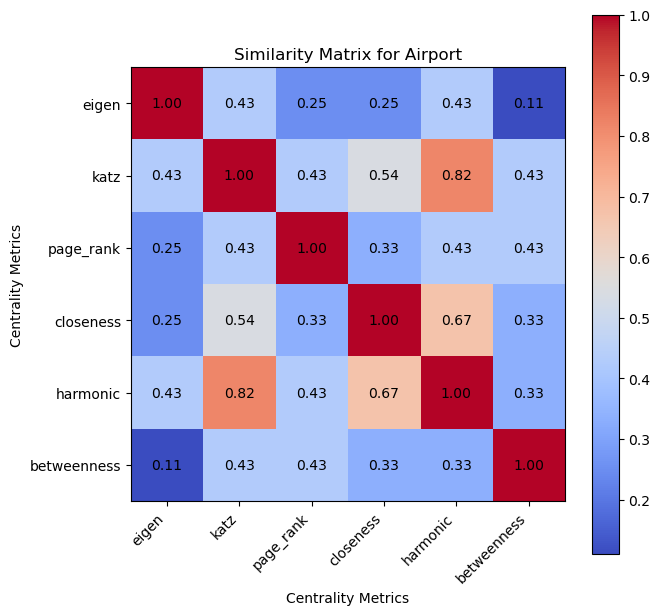

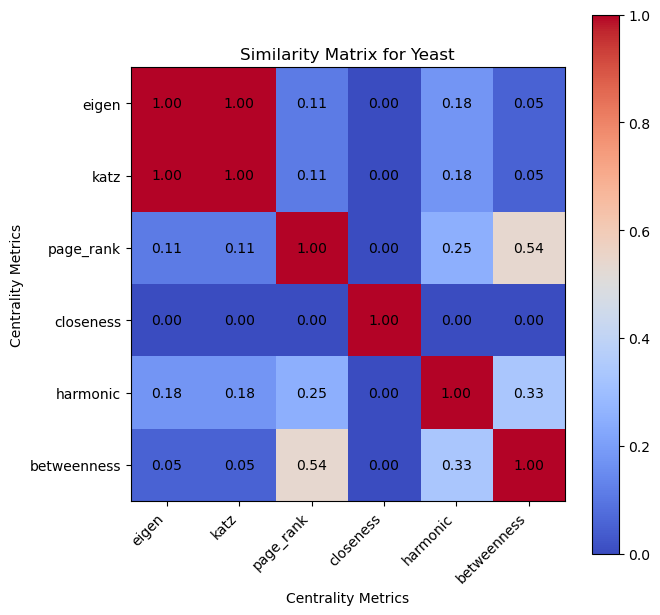

In [5]:
# Load the networks
G_airport, G_yeast = load_graphs()

# Get the top nodes
top_airport_nodes = top_10_nodes(G_airport)
top_yeast_nodes = top_10_nodes(G_yeast)

# Generate the similarity matrcies
top_nodes_dict = top_airport_nodes
node_similarity_airport = calculate_similarity_matrix(top_airport_nodes)
top_nodes_dict = top_yeast_nodes
node_similarity_yeast = calculate_similarity_matrix(top_yeast_nodes)

# Generate the heatmaps
plot_similarity_heatmap(node_similarity_airport, 'Airport')
plot_similarity_heatmap(node_similarity_yeast, 'Yeast')


## Written Response for 1.4

Answer:Based on the similarity matrix, for airport network, Katz centrality has high similarity with harmonic centrality (0.82). Therefore, Katz and harmonic centralities are useful for airport network to identify well-connected hubs. 
For Yeast network, the eigenvector centrality has perfect similarity with Katz(1.00), which means nodes are well-connected to other well-connected nodes.  

# Part 2: Community Detection with Zachary’s Karate Club [25 points]

### 2.1

In [6]:

def compute_cfinder_communities(G, k):
    """
    Inputs: G: NetworkX Graph Object

    Returns:
    community_assignments: list[int]
    """
    
    cliques = list(k_clique_communities(G, k))
    
    community_assignments = [-1] * len(G)
    for i, clique in enumerate(cliques):
        for node in clique:
            if community_assignments[node] == -1:
                community_assignments[node] = i
            else:
                community_assignments[node] = len(cliques)  # Assign to a new community for multiple memberships

    return community_assignments

def compute_greedy_communities(G):
    """
    Inputs: G: NetworkX Graph Object

    Returns:
    community_assignments: list[int]
    """
    communities = list(greedy_modularity_communities(G))
    
    community_assignments = [-1] * len(G)
    for i, community in enumerate(communities):
        for node in community:
            community_assignments[node] = i

    return community_assignments
    

def compute_louvain_communities(G):
    """
    Inputs: G: NetworkX Graph Object

    Returns:
    community_assignments: list[int]
    """
    communities = louvain_communities(G)
    
    community_assignments = [-1] * len(G)
    for i, community in enumerate(communities):
        for node in community:
            community_assignments[node] = i

    return community_assignments


### 2.2

In [7]:
def plot_network_communities(G, community_assignments, algorithm_name, save=False):
    """
    Inputs:
    G: NetworkX Graph Object
    community_assignments: list[int]
    algorithm_name: str
    """
    random.seed(1)
    np.random.seed(1)
    
    plt.figure(figsize=(5, 5))
    unique_communities = set(community_assignments)
    color_map = plt.cm.get_cmap('viridis', len(unique_communities))
    
    node_colors = [color_map(community_assignments[node]) for node in G.nodes]
    
    pos = nx.spring_layout(G, seed=42)  # For consistent layout
    nx.draw(G, pos, node_color=node_colors, with_labels=True, node_size=500, font_size=10, font_color='white', cmap=color_map)
    
    for community in unique_communities:
        plt.scatter([], [], c=[color_map(community)], label=f'Community {community}')
    plt.legend(loc='best')
    
    plt.title(f'Communities detected by {algorithm_name}')

    plt.show()
    if save:
        plt.savefig(f'karate_communities_{algorithm_name}.png')
    plt.close()

C:\Users\zhaoj\AppData\Local\Temp\ipykernel_16996\1001326237.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(unique_communities))
C:\Users\zhaoj\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


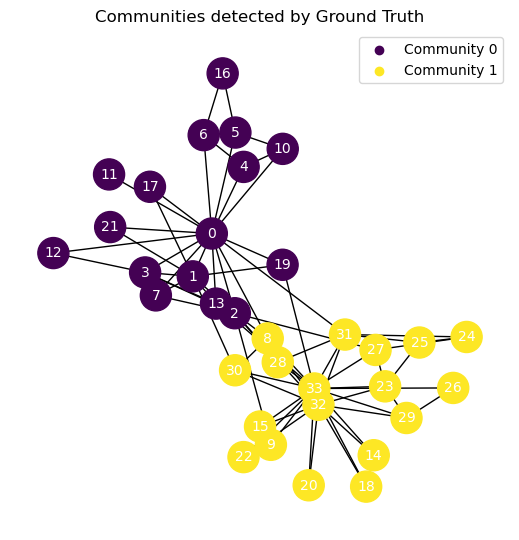

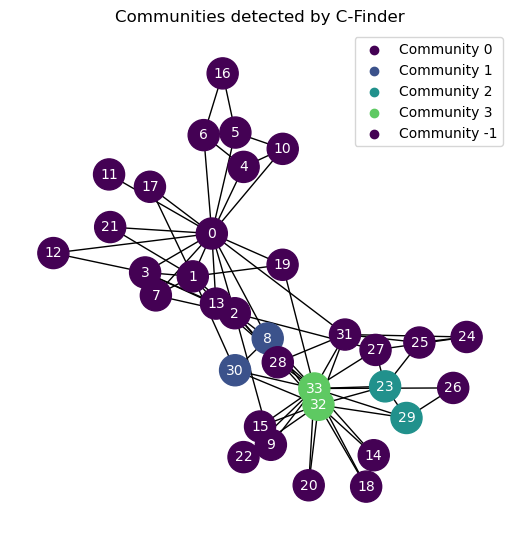

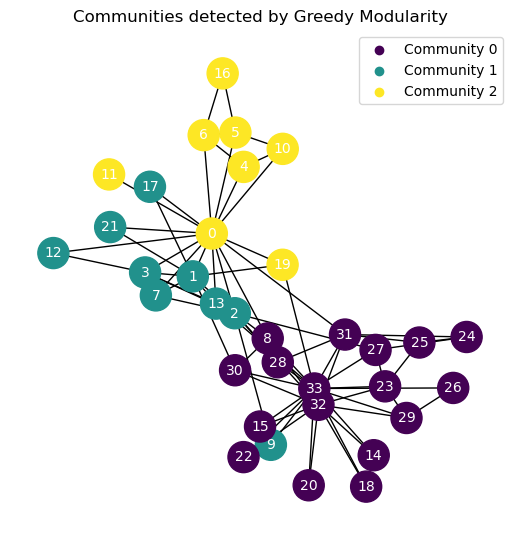

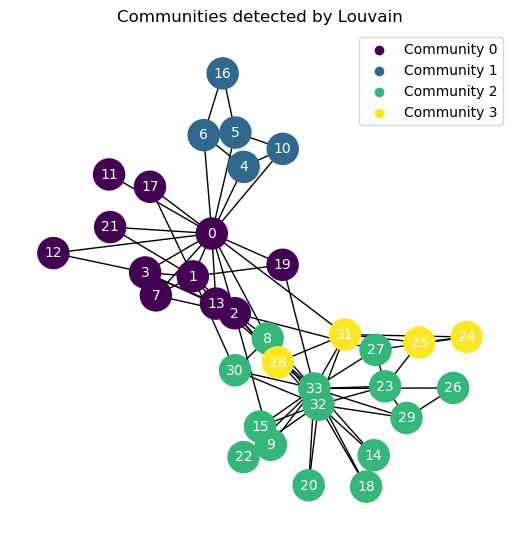

In [8]:
G = nx.karate_club_graph()
ground_truth = [0, 0, 0, 0, 0, 
                0, 0, 0, 1, 1, 
                0, 0, 0, 0, 1, 
                1, 0, 0, 1, 0, 
                1, 0, 1, 1, 1,
                1, 1, 1, 1, 1,
                1, 1, 1, 1]


# Chose a reasonable value for k in the cfinder algorithm 
cfinder_assignments = compute_cfinder_communities(G, k=4)
greedy_assignments = compute_greedy_communities(G)
louvain_assignments = compute_louvain_communities(G)


# Compare resulting community assignments with the ground truth
plot_network_communities(G, ground_truth, 'Ground Truth')
plot_network_communities(G, cfinder_assignments, 'C-Finder')
plot_network_communities(G, greedy_assignments, 'Greedy Modularity')
plot_network_communities(G, louvain_assignments, 'Louvain')


## Written Response for 2.3

Answer:The Louvain performed the best, based on its sub-community structure closely matching the ground truth and good modularity and community separation. The CFinder performed the worst based on it's multiple small communities and nodes belongs to multiple communities, in addition, it does not match the ground truth closely.

# Part 3: Community Detection with LFR Networks [25 points]

### 3.1

In [9]:
# Generating the LFR Benchmark Network
def generate_lfr_benchmark(mu):
    """
    Inputs:
    mu: float

    Returns:
    G: NetworkX Graph Object
    community_assignments: list[int]
    """
    
    n = 500
    tau1 = 2.5
    tau2 = 2
    min_degree = 3
    min_community = 40
    seed = 10
    
    G = LFR_benchmark_graph(n=n, tau1=tau1, tau2=tau2, mu=mu, min_degree = min_degree, min_community = min_community , seed=seed)
    
    community_assignments = [0] * n
    for node, node_data in G.nodes(data=True):  
        community_assignments[node] = list(node_data['community'])[0] + 1

    return G, community_assignments


### 3.2

In [10]:
def normalized_mutual_information(y_true, y_pred):
    """
    Inputs:
    y_true: list[int]
    y_pred: list[int]

    Returns:
    NMI: float
    """
    def mutual_information(y_true, y_pred):
        total = len(y_true)
        id_true = {val: idx for idx, val in enumerate(np.unique(y_true))}
        id_pred = {val: idx for idx, val in enumerate(np.unique(y_pred))}
        matrix = np.zeros((len(id_true), len(id_pred)), dtype=np.int32)

        for i in range(total):
            matrix[id_true[y_true[i]], id_pred[y_pred[i]]] += 1

        true_sum = np.sum(matrix, axis=1)
        pred_sum = np.sum(matrix, axis=0)
        
        mi = 0.0
        for i in range(len(id_true)):
            for j in range(len(id_pred)):
                if matrix[i, j] > 0:
                    mi += matrix[i, j] / total * np.log(matrix[i, j] * total / (true_sum[i] * pred_sum[j]))
                    
        return mi
    def entropy(labels):
        total = len(labels)
        id_labels = {val: idx for idx, val in enumerate(np.unique(labels))}
        probs = np.zeros(len(id_labels), dtype=np.float64)

        for label in labels:
            probs[id_labels[label]] += 1
        
        probs /= total
        return -np.sum(probs * np.log(probs))

    mi = mutual_information(y_true, y_pred)
    h_true = entropy(y_true)
    h_pred = entropy(y_pred)
    
    NMI= mi / np.sqrt(h_true * h_pred)
    

    return NMI
    print(communities1, communities2())

### 3.3

In [11]:
def sweep_mu_values():
    """
    
    Returns:
    greedy_nmis: list[float]
    louvain_nmis: list[float]
    
    """
    mu_values = np.linspace(0.1, 1.0, 10)
    greedy_nmis = []
    louvain_nmis = []
    
    for mu in mu_values:
        G, ground_truth = generate_lfr_benchmark(mu)
        
        greedy_assignments = compute_greedy_communities(G)
        louvain_assignments = compute_louvain_communities(G)
        
        greedy_nmi = normalized_mutual_information(ground_truth, greedy_assignments)
        louvain_nmi = normalized_mutual_information(ground_truth, louvain_assignments)
        
        greedy_nmis.append(greedy_nmi)
        louvain_nmis.append(louvain_nmi)

    return greedy_nmis, louvain_nmis

### 3.4

In [12]:
def plot_nmi_values(greedy_nmis, louvain_nmis, save=False):
    """
    Inputs:
    greedy_nmis: list[int]
    louvain_nmis: list[int]
    """
    plt.figure(figsize=(8,6))

    mu_values = np.linspace(0.1, 1.0, 10)

    plt.figure(figsize=(8, 6))
    plt.plot(mu_values, greedy_nmis, label='Greedy Modularity', marker='o')
    plt.plot(mu_values, louvain_nmis, label='Louvain', marker='o')
    plt.xlabel('Mu')
    plt.ylabel('NMI')
    plt.title('NMI as a function of Mu')
    plt.legend()


    plt.show()
    
    if save:
        plt.savefig('3_4.png')
    plt.close()

### 3.5

<Figure size 800x600 with 0 Axes>

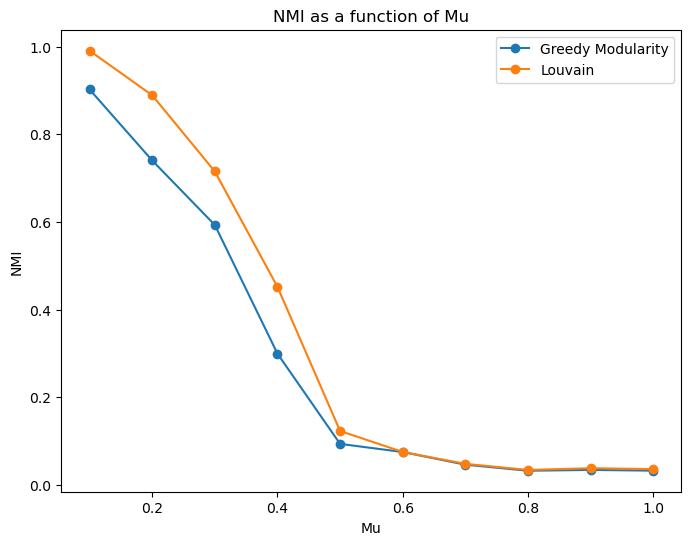

In [13]:
greedy_nmis, louvain_nmis = sweep_mu_values()

plot_nmi_values(greedy_nmis, louvain_nmis)

NameError: name 'y_true' is not defined

## Written Response for 3.5

Answer:The NMI for Greedy Modularity and Louvain starts high and decreased quickly when mu increase from 0.1 to 0.5. However, Louvain's NMI is higher than Greedy Modularitys NMI before reaching to mu = 0.6. Therefore Louvain perferm better than Greedy Modularity before mu is reaching to 0.6, and then both perferm same between mu is ranged from 0.6 to 1. 
The NMI measure how well the detected communities matching he ground truth. The higher the NMI values, the better performance. 
The mu impacts on the performance of algorithm, the higher the mu, the lower the NMI.

# Part 4: Community Detection on Real World Data [15 points]

### 4.1

In [64]:
from networkx.algorithms.community import k_clique_communities
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import louvain_communities, louvain_partitions
def calculate_community_sizes(G):
    """
    Inputs:
    G: NetworkX Graph Object

    Returns: 
    greedy_sizes: list[int]
    louvain_sizes: list[int]
    """
    greedy_communities = list(greedy_modularity_communities(G))
    greedy_sizes = [len(c) for c in greedy_communities]
    
    louvain_coms = louvain_communities(G)
    louvain_sizes = [len(c) for c in louvain_coms]
    """
    louvain_partition = list(louvain_partitions(G))[-1]  # Get the final partition
    louvain_communities = {}
    for node, community_id in louvain_partition.items():
        if community_id not in louvain_communities:
            louvain_communities[community_id] = []
        louvain_communities[community_id].append(node)
    louvain_sizes = [len(c) for c in louvain_communities.values()]
    """
    """
    for node, community_id in louvain_partition.items():
        if community_id not in louvain_communities:
            louvain_communities[community_id] = []
        louvain_communities[community_id].append(node)
    louvain_sizes = [len(c) for c in louvain_communities.values()]
    """

    return greedy_sizes, louvain_sizes

### 4.2

In [80]:
def plot_community_size_distributions(greedy_sizes, louvain_sizes, data_name, save=False):
    """
    Inputs:
    greedy_sizes: list[int]
    louvain_sizes: list[int]
    data_name: str
    """

    plt.figure(figsize=(20,6))

    plt.hist(greedy_sizes, bins=10, alpha=0.5, label='Greedy Modularity', color='blue')

    plt.hist(louvain_sizes, bins=10, alpha=0.5, label='Louvain', color='green')

    plt.xlabel('Community Size')
    plt.ylabel('Frequency')
    plt.title(f'Community Size Distribution for {data_name}')
    plt.legend()


    plt.show()
    
    if save:
        plt.savefig('4_2.png')
    plt.close()
    

In [81]:
print(greedy_modularity_communities(G))
print(louvain_communities(G))

[frozenset({8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}), frozenset({1, 2, 3, 7, 9, 12, 13, 17, 21}), frozenset({0, 16, 19, 4, 5, 6, 10, 11})]
[{0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21}, {16, 4, 5, 6, 10}, {32, 33, 8, 9, 14, 15, 18, 20, 22, 23, 26, 27, 29, 30}, {24, 25, 28, 31}]


### 4.3

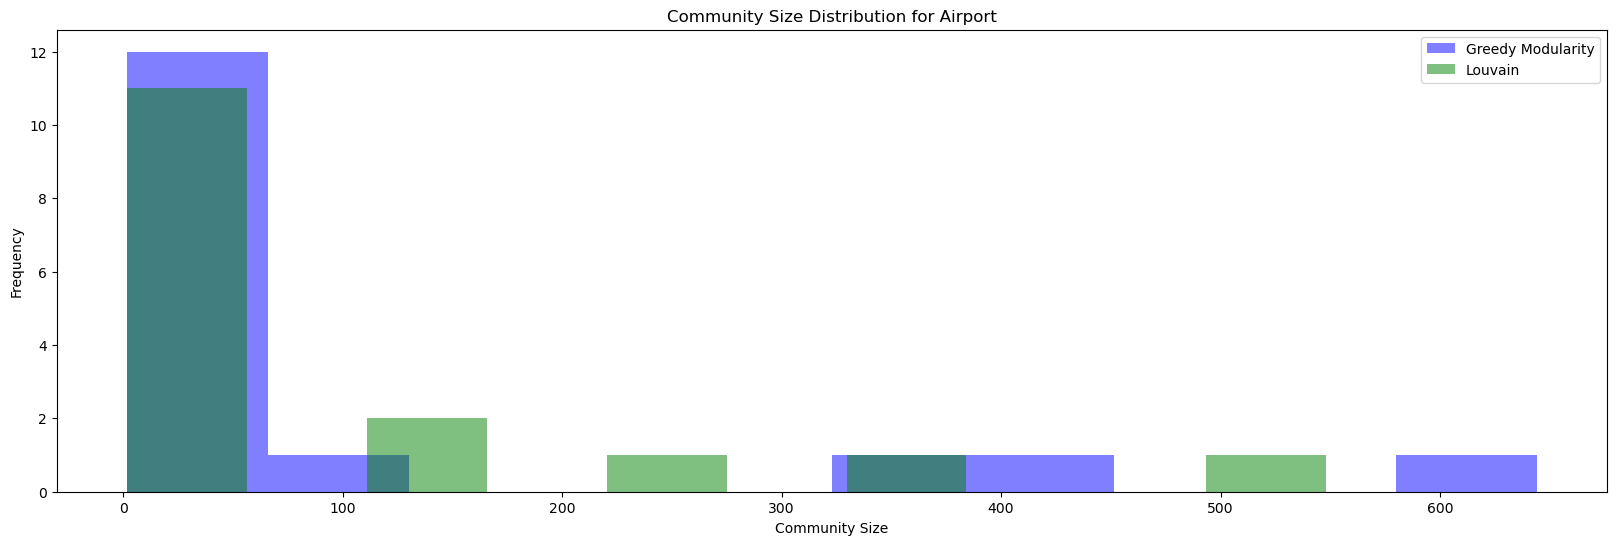

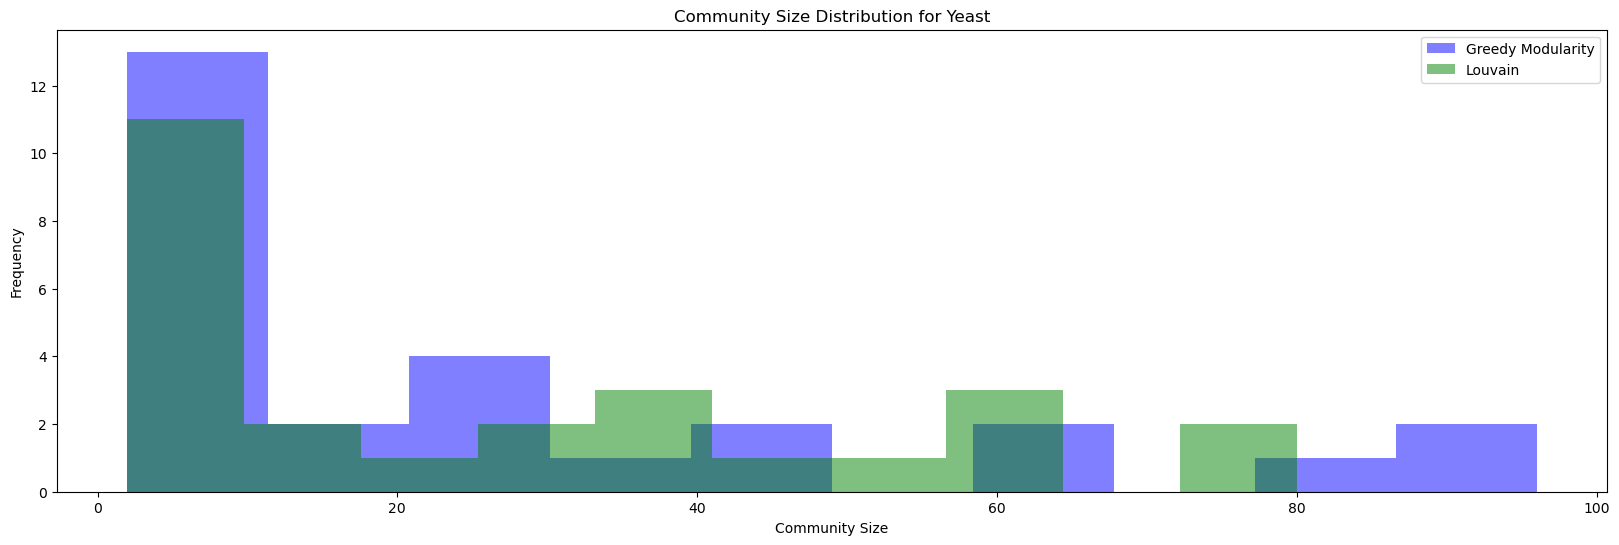

In [82]:
G_airport, G_yeast = load_graphs()

# Airport
greedy_sizes, louvain_sizes = calculate_community_sizes(G_airport)
plot_community_size_distributions(greedy_sizes, louvain_sizes, 'Airport')

# Yeast
greedy_sizes, louvain_sizes = calculate_community_sizes(G_yeast)
plot_community_size_distributions(greedy_sizes, louvain_sizes, 'Yeast')

## Written Response for 4.3

Answer:For Airport network, both algorithms' sizes are more allocated in the small communities.However, Louvain has more serveral mid-sized communities comparing with Greedy Modularity. Therefore, Louvain can provide a more balanced community size distribution. 
For Yeast network,both algorithms' sizes are more allocated in the small communities.However, Louvain provides a more varied size distribution. Overall, the Louvain algorithm can give a more balanced view of community sizes which mean it is more suitable for community structure which are complex and varied. 

## Response for 5



### Partition 1:

Image:partition 1.png

Modularity: There is only one community, so the are the internal edges is same as total edges which is 19, and sum of degrees is 38 as each edge links two nodes. 19/19-(38/(2*19))^2 = 0

### Partition 2:

Image:partition 2.png

Modularity: there is no internal edge for each community, there are 1 community with 2 degrees, 8 community with 3 degrees and 3 community with 4 degrees
((0/19)-(2/(2*19))^2) + 8 x ((0/19)-(3/(2*19))^2)+ 3 x ((0/19)-(4/(2*19))^2)=  - 0.0859

### Partition 3:

Image:partition 3.png

Modularity: there is no edge or internal edge or degree for each community. (0/0)-((0/0)^2) which leads to an error. so the modularity is invalid

### Partition 4:

Image:partition 4.png

Modularity: there are 16 edges in total, each community has 10,16 and 6 degrees respectively. 
((5/16)-(10/32)^2)+((8/16)-(16/32)^2)+((3/16)-(6/32)^2) = 0.617

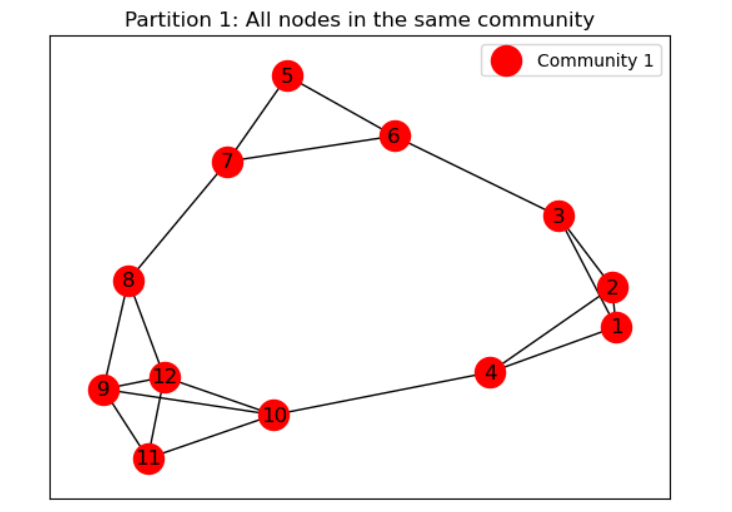

In [3]:
Image.open('partition 1.png')

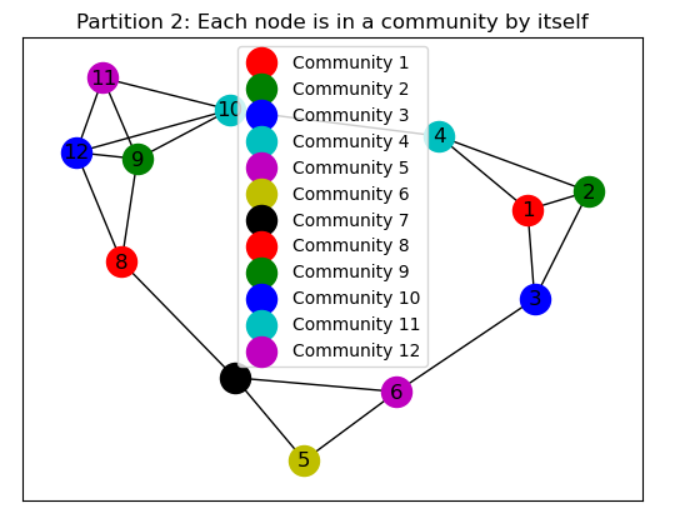

In [4]:
Image.open('partition 2.png')

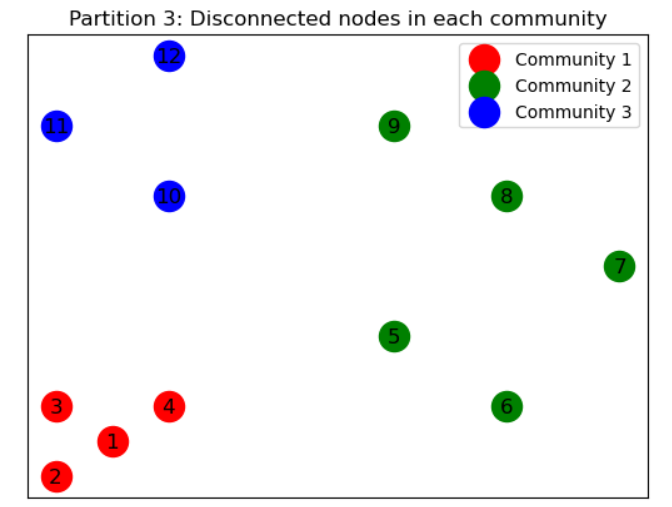

In [6]:
Image.open('partition 3.png')

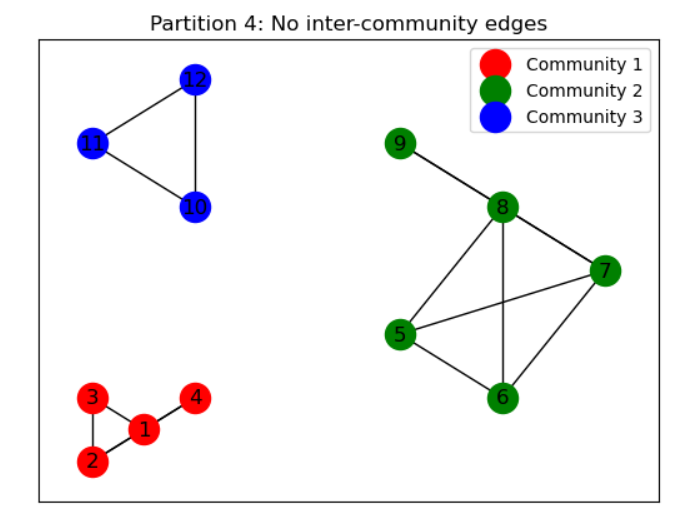

In [7]:
Image.open('partition 4.png')